# **27. Stable Diffusion, 너 Do? 나 Do! [프로젝트]**

## **27-1. Project: Stable diffusion 실습**

# Stable Diffusion

### Install packages (pytorch)

In [ ]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio diffusers transformers accelerate --upgrade --quiet

### Import Libraries

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

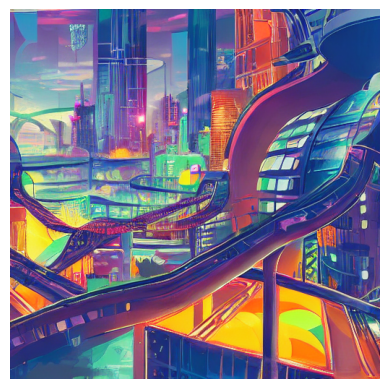

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image

# GPU가 사용 가능한지 확인하고, 사용 가능한 경우 GPU와 float16을 설정합니다.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Pre-trained Stable Diffusion 모델을 불러옵니다.
# 모델 아이디는 원하는 버전(예: "CompVis/stable-diffusion-v1-4" 또는 "runwayml/stable-diffusion-v1-5")에 따라 조정할 수 있습니다.
model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

# 이제 pipe를 사용하여 텍스트-투-이미지 생성 등을 수행할 수 있습니다.
prompt = "A futuristic cityscape, vibrant and detailed"
image = pipe(prompt).images[0]

# 생성된 이미지를 출력합니다.
plt.imshow(np.array(image))
plt.axis("off")
plt.show()

### Interpolating between text prompts
1. encoded to vector
2. diffusion process
3. latent vector shape [77, 768]

text prompt to generate image from latent manifold.

In [ ]:
# 프롬프트와 보간 단계 수 정의
prompt_1 = "A futuristic cityscape, vibrant and detailed"
prompt_2 = "A robotic wolf with glowing red eyes, cybernetic design, cinematic background"
interpolation_steps = 3

# 토크나이저를 사용해 텍스트를 토큰화합니다.
inputs_1 = pipe.tokenizer(prompt_1, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")
inputs_2 = pipe.tokenizer(prompt_2, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")

# CPU에 있는 텐서를 GPU로 이동
inputs_1 = {k: v.to(device) for k, v in inputs_1.items()}
inputs_2 = {k: v.to(device) for k, v in inputs_2.items()}

# 텍스트 인코더를 사용해 프롬프트의 임베딩을 얻습니다.
with torch.no_grad():
    encoding_1 = pipe.text_encoder(**inputs_1).last_hidden_state  # shape: (1, seq_len, emb_dim)
    encoding_2 = pipe.text_encoder(**inputs_2).last_hidden_state

# 배치 차원 제거 (1, seq_len, emb_dim) -> (seq_len, emb_dim)
encoding_1 = encoding_1.squeeze(0)
encoding_2 = encoding_2.squeeze(0)

# 두 인코딩 사이를 선형 보간합니다.
alphas = torch.linspace(0, 1, steps=interpolation_steps, device=encoding_1.device)
# 각 보간 단계마다 encoding_1과 encoding_2의 가중 평균을 계산합니다.
interpolated_encodings = [(1 - alpha) * encoding_1 + alpha * encoding_2 for alpha in alphas]
# 보간 결과를 하나의 텐서로 스택 (shape: (interpolation_steps, seq_len, emb_dim))
interpolated_encodings = torch.stack(interpolated_encodings)

# 임베딩의 shape 출력
print(f"Encoding shape: {encoding_1.shape}")

Encoding shape: torch.Size([77, 768])


Interpolated the encodings, maintaining some stabiity bewteen the resulted images to keep the diffusion noise constant between images.

인코딩을 보간한 뒤 이미지를 생성할 때, 결과 이미지 간의 일관성을 유지하기 위해 디퓨전 노이즈는 고정합니다.

In [ ]:
# 시드 설정 및 생성기 초기화
seed = 123
generator = torch.Generator(device=device).manual_seed(seed)

# latent 공간 크기: (batch_size, 4, height, width)
latent_height = 512 // 8  # 64
latent_width = 512 // 8   # 64

# interpolation_steps 만큼의 노이즈(초기 잠재 변수)를 생성
latents = torch.randn(
    (interpolation_steps, 4, latent_height, latent_width),
    generator=generator,
    dtype=torch.float16,
    device=device
)

# latents에 미리 생성한 노이즈를 전달합니다.
images = pipe(
    prompt_embeds=interpolated_encodings,
    latents=latents,
    generator=generator
).images

GIF image 파일이 image sequence 로 저장 하고 시간에 따라 어떻게 변화하는지를 보여줌으로써, 변화 과정등을 시각화해서 보여줄 수 있습니다.

하지만, image sequence로 저장하고 이미지의 시간에 따라 변화는 모습을 보여줄때, 처음 이미지와 마지막 이미지가 내용상 연결이 되지 않을 경우에는, GIF를 되감기하여 자연스럽게 만들어줄 수 있습니다.
이 기법을 "**rubber-band the gif**" 라고 합니다.

예시 고양이 -> 개 -> 고양이로 돌아오게끔 만들어서 GIF 가 (loop) 되게 할수 있는 기법입니다.

In [ ]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )

export_as_gif(
    "picture_1.gif",
    images,
    frames_per_second=2,
    rubber_band=True,
)

# 결과 분석

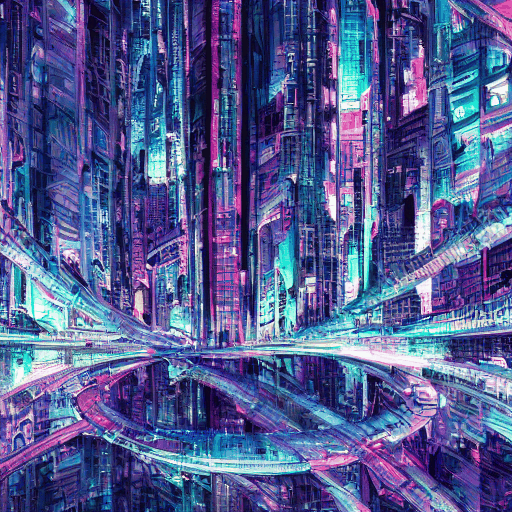

In [ ]:
from IPython.display import Image, display

# 생성된 GIF 보기
display(Image(filename="picture_1.gif"))

  0%|          | 0/50 [00:00<?, ?it/s]

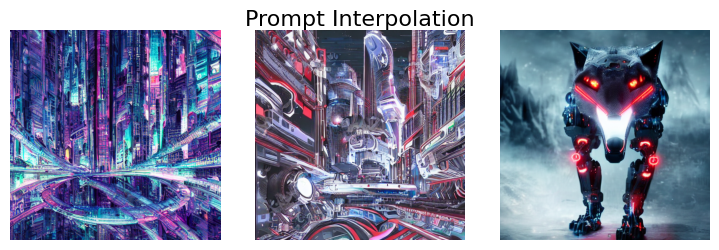

In [ ]:
images = pipe(
    prompt_embeds=interpolated_encodings,
    latents=latents,
    generator=generator
).images


def show_images_grid(images, cols=5, title="Interpolation Grid", rubber_band=False):
    # rubber_band 효과 적용 시 대칭 이미지 추가
    if rubber_band:
        images = images + images[2:-1][::-1]

    total = len(images)
    rows = (total + cols - 1) // cols

    plt.figure(figsize=(cols * 2.5, rows * 2.5))
    plt.suptitle(title, fontsize=16)

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# GIF를 위한 rubber_band 옵션이 True인 경우 시각화도 동일하게 적용
show_images_grid(images, cols=interpolation_steps, title="Prompt Interpolation", rubber_band=True)


In [ ]:

# 설정
interpolation_steps = 150  # 원래 생성할 샘플 수
batch_size = 3

# interpolated_encodings는 이전에 (interpolation_steps, 77, 768) 모양으로 생성됨
total = interpolated_encodings.shape[0]
num_batches = math.ceil(total / batch_size)
padding_size = num_batches * batch_size - total

if padding_size > 0:
    # 마지막 샘플을 복제해서 패딩 (여기서는 마지막 샘플을 반복)
    pad_encodings = interpolated_encodings[-1:].expand(padding_size, -1, -1)
    interpolated_encodings = torch.cat([interpolated_encodings, pad_encodings], dim=0)

# 이제 전체 샘플 수는 num_batches * batch_size가 됨
batched_encodings = torch.split(interpolated_encodings, batch_size)

# 잠재(latent) 공간의 크기 계산 (일반적으로 512/8 = 64)
latent_height = 512 // 8  # 64
latent_width = 512 // 8   # 64

# 각 보간 단계마다 사용할 노이즈(초기 잠재 변수)를 생성합니다. noise 텐서의 shape: (interpolation_steps, 4, latent_height, latent_width)
noise = torch.randn(
    (total, 4, latent_height, latent_width),
    generator=generator,
    dtype=torch.float16,
    device=device
)
# noise도 배치 크기의 배수가 아니면 패딩
if padding_size > 0:
    pad_noise = noise[-1:].expand(padding_size, 4, latent_height, latent_width)
    noise = torch.cat([noise, pad_noise], dim=0)

batched_latents = torch.split(noise, batch_size)

# 배치별로 이미지를 생성합니다.
images = []
for i in range(len(batched_encodings)):
    output = pipe(
        prompt_embeds=batched_encodings[i],
        latents=batched_latents[i],
        num_inference_steps=25,
        generator=generator
    )
    images += output.images

export_as_gif("picture-150.gif", images, rubber_band=True)

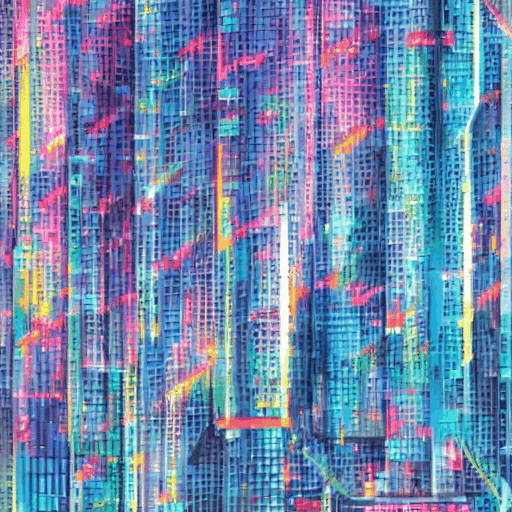

  0%|          | 0/25 [00:00<?, ?it/s]

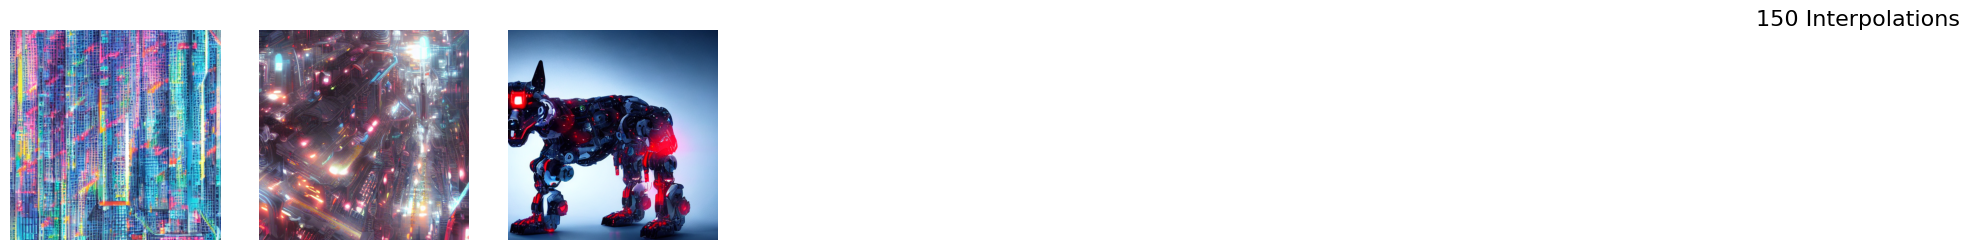

In [ ]:

from IPython.display import Image, display

# GIF를 정적 이미지처럼 표시
display(Image(filename="picture-150.gif"))


alphas = torch.linspace(0, 1, steps=150, device=pipe.device)
interpolated_encodings = torch.stack([
    (1 - alpha) * encoding_1 + alpha * encoding_2 for alpha in alphas
])

images = []
for i in range(len(batched_encodings)):
    output = pipe(
        prompt_embeds=batched_encodings[i],
        latents=batched_latents[i],
        num_inference_steps=25,
        generator=generator
    )
    images += output.images


show_images_grid(images, cols=15, title="150 Interpolations", rubber_band=False)


In [ ]:

# 설정
interpolation_steps = 150  # 원래 생성할 샘플 수
batch_size = 3

# interpolated_encodings는 이전에 (interpolation_steps, 77, 768) 모양으로 생성됨
total = interpolated_encodings.shape[0]
num_batches = math.ceil(total / batch_size)
padding_size = num_batches * batch_size - total

if padding_size > 0:
    # 마지막 샘플을 복제해서 패딩 (여기서는 마지막 샘플을 반복)
    pad_encodings = interpolated_encodings[-1:].expand(padding_size, -1, -1)
    interpolated_encodings = torch.cat([interpolated_encodings, pad_encodings], dim=0)

# 이제 전체 샘플 수는 num_batches * batch_size가 됨
batched_encodings = torch.split(interpolated_encodings, batch_size)

# 잠재(latent) 공간의 크기 계산 (일반적으로 512/8 = 64)
latent_height = 512 // 8  # 64
latent_width = 512 // 8   # 64

# 각 보간 단계마다 사용할 노이즈(초기 잠재 변수)를 생성합니다. noise 텐서의 shape: (interpolation_steps, 4, latent_height, latent_width)
noise = torch.randn(
    (total, 4, latent_height, latent_width),
    generator=generator,
    dtype=torch.float16,
    device=device
)
# noise도 배치 크기의 배수가 아니면 패딩
if padding_size > 0:
    pad_noise = noise[-1:].expand(padding_size, 4, latent_height, latent_width)
    noise = torch.cat([noise, pad_noise], dim=0)

batched_latents = torch.split(noise, batch_size)

# 배치별로 이미지를 생성합니다.
images = []
for i in range(len(batched_encodings)):
    output = pipe(
        prompt_embeds=batched_encodings[i],
        latents=batched_latents[i],
        num_inference_steps=25,
        generator=generator
    )
    images += output.images

export_as_gif("picture-150.gif", images, rubber_band=True)

In [ ]:
from IPython.display import Image, display

# GIF를 정적 이미지처럼 표시
display(Image(filename="picture-150.gif"))


alphas = torch.linspace(0, 1, steps=150, device=pipe.device)
interpolated_encodings = torch.stack([
    (1 - alpha) * encoding_1 + alpha * encoding_2 for alpha in alphas
])

images = []
for i in range(len(batched_encodings)):
    output = pipe(
        prompt_embeds=batched_encodings[i],
        latents=batched_latents[i],
        num_inference_steps=25,
        generator=generator
    )
    images += output.images


show_images_grid(images, cols=15, title="150 Interpolations", rubber_band=False)


# 평가 및 회고

아래의 기준을 바탕으로 프로젝트를 평가합니다.<br>
<br>

|평가문항|상세기준|
|-|-|
|<br>1. 잠재적 표현의 변화가 모델 출력에 미치는<br> 영향을 관찰하였는가?<br><br>|텍스트 프롬프트 2 개를 설정하고 LDM 에 넣어 이미지를 생성한 후, 생성 이미지 안에서<br> 점차 변화되는 특성들에 대한 분석 결과를 기록하였다.|
|<br>2. Stable diffusion 모델의 dreambooth<br> 미세조정을 실습하였는가?<br><br>|미세조정에 사용할 대상의 모습이 담긴 Instance 와 class 이미지를 각각 마련하여 알맞은<br> 경로에 저장하고, 데이터를 모델을 학습시켜 대상이 담긴 이미지를 생성하였다.|
|<br>3. 나만의 취향이 담긴 생성 이미지를<br> 만들어보았는가?<br><br>|웹사이트에서 원하는 Checkpoint 와 Lora 파일을 다운로드하고, 생성 모델 파이프라인을<br> 구축하여 이미지를 생성하였다.|

평가

평가는 기존 루브릭에 해당하는 실험들을 이행해보았습니다.

회고

일단 코드가 업데이트 되면서 진행에 많은 어려움이 있었고 이 부분들을 해소해나가기 위해서 정말 많은 시간을 투자한거 같은데, 이 문제를 해소해 나가려는 과정에서 투자한 시간 대비 많은 효율성을 떨어뜨린 상태에서 일을 진행함으로 좀 그 부분이 아쉬웠다. 목적을 달성하는 것도 좋지만, 그 전에 스스로 어떻게 문제를 해결 할것인지에 대한 깊은 고민을 해보았어야 할것 같다. 일단 무작정 계속 해보자 라는 것 보다는 왜를 계속 스스로 생각하면서 문제에 대한 접근을 했어야 하고 정리를 여러모로 했어야 했다고 생각한다. 문제를 풀기보다도 그 문제에 대해서 이해도가 어느정도 스스로 높였어야 하고 그 문제를 접근했다면 좀더 수월하게 효율적인 방법으로 문제를 해소 하지 않았을까 생각해본다.